## 全连接卷积神经网络
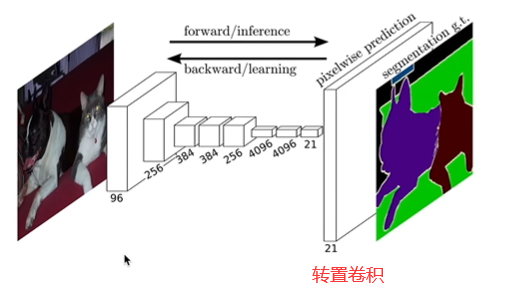

CNN的最后两层要么就是全连接层Linear，要么就是一个全局平均池化层（k个通道，每个通道做个平均变成1x1，存放对不同类别的预测）

FCN再CNN后面先使用1x1的卷积降低通道数，主要为了降低计算量，再接一个转置卷积层，将图片还原成原图的尺寸，通道数为类别数，即：每个像素对不同类别的预测存在通道中

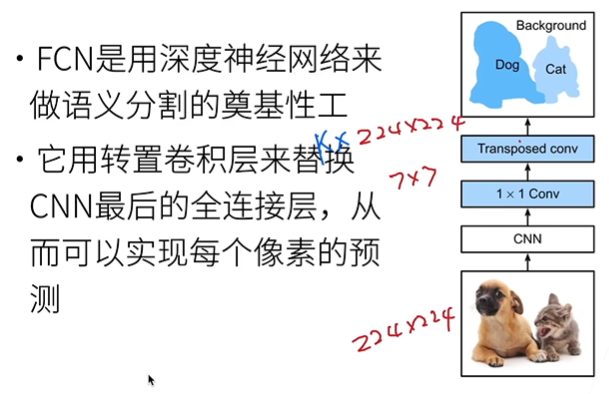

In [1]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [3]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

## 构造网络模型
全连接卷积神经网络先使用卷积神经网络做特征提取，再使用1x1的卷积层将通道数变为类别个数，最后再使用转置卷积层将特征图的高宽变成输入图像的高宽

下面，我们使用在ImageNet数据集上预训练的ResNet-18模型来提取图像特征，并将该网络记为pretrained_net。 ResNet-18模型的最后几层包括全局平均汇聚层和全连接层，然而全卷积网络中不需要它们。

In [5]:
pretrained_net =  torchvision.models.resnet18(pretrained=True)
# 查看该网络最后三层的结构
list(pretrained_net.children())[-3:]

[Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (downsample): Sequential(
       (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
       (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
   )
   (1): BasicBlock(
     (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): Batc

我们丢弃该网络结构中的最后两层

In [6]:
net = nn.Sequential(*list(pretrained_net.children())[:-2])

给定输入图像320x480，经过net的前向传播后高宽减少至原来的1/32，即：10x15

In [7]:
X = torch.rand(size=(1, 3, 320, 480))
net(X).shape

torch.Size([1, 512, 10, 15])

使用1x1卷积，将通道数变为类别数（减少计算量）

In [8]:
num_classes = 21
net.add_module('final_conv', nn.Conv2d(512, num_classes, kernel_size=1))

使用转置卷积层修改特征图的高宽为输入图像的高宽

In [9]:
net.add_module('transpose_conv', nn.ConvTranspose2d(num_classes, num_classes,
                                                    kernel_size=64, stride=32, padding=16))

### 初始化转置卷积层
在图像处理中，我们有时需要将图像放大，即上采样（upsampling）。 双线性插值（bilinear interpolation） 是常用的上采样方法之一，它也经常用于初始化转置卷积层。

In [10]:
def bilinear_kernel(in_channels, out_channels, kernel_size):
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = (torch.arange(kernel_size).reshape(-1, 1),
          torch.arange(kernel_size).reshape(1, -1))
    filt = (1 - torch.abs(og[0] - center) / factor) * \
           (1 - torch.abs(og[1] - center) / factor)
    weight = torch.zeros((in_channels, out_channels,
                          kernel_size, kernel_size))
    weight[range(in_channels), range(out_channels), :, :] = filt
    return weight

In [11]:
# 高宽放大2倍的转置卷积层
conv_trans = nn.ConvTranspose2d(3, 3, kernel_size=4, padding=1, stride=2,
                                bias=False)
# 使用双线性插值初始化其权重
conv_trans.weight.data.copy_(bilinear_kernel(3, 3, 4));

In [12]:
img = torchvision.transforms.ToTensor()(d2l.Image.open('../img/catdog.jpg'))
X = img.unsqueeze(0)
Y = conv_trans(X)

out_img = Y[0].permute(1, 2, 0).detach()

可以看到，转置卷积层将输入图像的高和宽分别放大了2倍。 除了坐标刻度不同，双线性插值放大的图像和原图看上去没什么区别

input image shape: torch.Size([561, 728, 3])
output image shape: torch.Size([1122, 1456, 3])


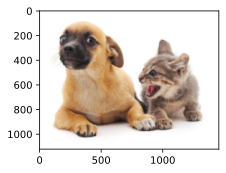

In [13]:
d2l.set_figsize()
print('input image shape:', img.permute(1, 2, 0).shape)
d2l.plt.imshow(img.permute(1, 2, 0));
print('output image shape:', out_img.shape)
d2l.plt.imshow(out_img);

全卷积网络用双线性插值初始化转置卷积层，对于1x1的卷积层使用Xavier初始化参数

In [14]:
W = bilinear_kernel(num_classes, num_classes, 64)
net.transpose_conv.weight.data.copy_(W)

至此我们完成了整个网络的搭建以及初始化

## 加载数据集

In [15]:
batch_size, crop_size = 32, (320, 480)
train_iter, test_iter = d2l.load_data_voc(batch_size, crop_size)

read 1114 examples
read 1078 examples


## 训练
现在我们可以训练全卷积网络了。 这里的损失函数和准确率计算与图像分类中的并没有本质上的不同，因为我们使用转置卷积层的通道来预测像素的类别。 此外，模型基于每个像素的预测类别是否正确来计算准确率。

loss 0.423, train acc 0.867, test acc 0.852
48.3 examples/sec on [device(type='cuda', index=0)]


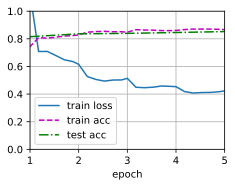

In [16]:
def loss(inputs, targets):
    # 一个样本cross_entropy的结果是一个矩阵，每个元素代表每个像素预测的损失
    # 依次对高宽求均值，得到一个样本所有像素预测的损失均值
    return F.cross_entropy(inputs, targets, reduction='none').mean(1).mean(1)

num_epochs, lr, wd, devices = 5, 0.001, 1e-3, d2l.try_all_gpus()
trainer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=wd)
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

## 预测
在预测时，我们需要将输入图像在各个通道做标准化，并转成卷积神经网络所需要的四维输入格式。

In [17]:
def predict(img):
    """得到图片每个像素类别的预测，是一张类别标签构成的图"""
    X = test_iter.dataset.normalize_image(img).unsqueeze(0)
    # 按通道维找最大值所在索引（代表其类别索引）
    pred = net(X.to(devices[0])).argmax(dim=1)
    return pred.reshape(pred.shape[1], pred.shape[2])

为了可视化语义分割的结果，我们将每个像素的类别索引映射回它们在数据集中的对应的RGB颜色

In [24]:
def label2image(pred):
    """将类别标签图转换成对应的彩图"""
    colormap = torch.tensor(d2l.VOC_COLORMAP, device=devices[0])
    X = pred.long()
    return colormap[X, :]

为简单起见，我们只读取几张较大的测试图像，并从图像的左上角开始截取形状为 320 x 480 的区域用于预测。 对于这些测试图像，我们逐一打印它们截取的区域，再打印预测结果，最后打印标注的类别。

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
      dtype=object)

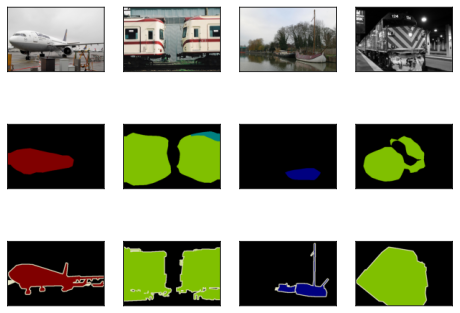

In [31]:
voc_dir = d2l.download_extract('voc2012', 'VOCdevkit/VOC2012')
test_images, test_labels = d2l.read_voc_images(voc_dir, False)
n, imgs = 4, []
for i in range(n):
    crop_rect = (0, 0, 320, 480)
    X = torchvision.transforms.functional.crop(test_images[i], *crop_rect)
    pred = label2image(predict(X))
    # 逐一保存原图截取后的部分，预测结果彩图，标签彩图
    imgs += [X.permute(1, 2, 0), pred.cpu(), 
            torchvision.transforms.functional.crop(
                test_labels[i], *crop_rect).permute(1, 2, 0)]
    
d2l.show_images(imgs[::3] + imgs[1::3] + imgs[2::3], # 原图排一起,预测排一起，标签排一起
                3, n, scale=2)